In [1]:
# Default style guide
from matplotlib import style
style.use('fivethirtyeight')

# Import the dependencies
import pandas as pd
import numpy as np
import datetime

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# ORM Stuff
import sqlalchemy
from sqlalchemy import create_engine, inspect, text, func
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
tables = inspector.get_table_names()

# Using the inspector to print the column names within the 'dow' table and its types
for table in tables:
    print(table)
    print("--------")
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

    print()

measurement
--------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
--------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



In [4]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [5]:
#Assign the measurement class to a variable called "Measurement and station class to variable called "Station"
Station = Base.classes.station
Measurement = Base.classes.measurement

In [6]:
#Create a session
session = Session(engine) #ORM
conn = engine.connect() #Raw SQL/Pandas

In [7]:
#Data Station
query = text("""SELECT * From station LIMIT 10""")
df = pd.read_sql(query, con=conn)
df

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [8]:
#Data Measurement
query = text("""SELECT * From measurement where date ='2010-01-01' LIMIT 10""")
df = pd.read_sql(query, con=conn)
df

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2725,USC00513117,2010-01-01,0.28,67.0
2,9008,USC00518838,2010-01-01,0.21,72.0
3,9519,USC00519523,2010-01-01,0.15,75.0
4,12188,USC00519281,2010-01-01,0.15,70.0
5,14960,USC00511918,2010-01-01,0.05,66.0
6,16939,USC00516128,2010-01-01,0.14,73.0


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
query = text("""SELECT max(date) from measurement;""")
conn.execute(query).fetchall()

[('2017-08-23',)]

In [10]:
session.query(func.max(Measurement.date)).all()

[('2017-08-23',)]

In [11]:
# ORM
rows = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp).filter(Measurement.date >= '2016-08-23').order_by(Measurement.date).all()
df1a = pd.DataFrame(rows)
df1a.head()

,id,station,date,prcp
0,2364,USC00519397,2016-08-23,0.00
1,5091,USC00513117,2016-08-23,0.15
2,7331,USC00514830,2016-08-23,0.05
3,8825,USC00517948,2016-08-23,NaN
4,11851,USC00519523,2016-08-23,0.02


In [12]:
df1a = df1a.sort_values(by="date")
df1a.head()

,id,station,date,prcp
0,2364,USC00519397,2016-08-23,0.00
1,5091,USC00513117,2016-08-23,0.15
2,7331,USC00514830,2016-08-23,0.05
3,8825,USC00517948,2016-08-23,NaN
4,11851,USC00519523,2016-08-23,0.02


<Figure size 1000x1200 with 0 Axes>

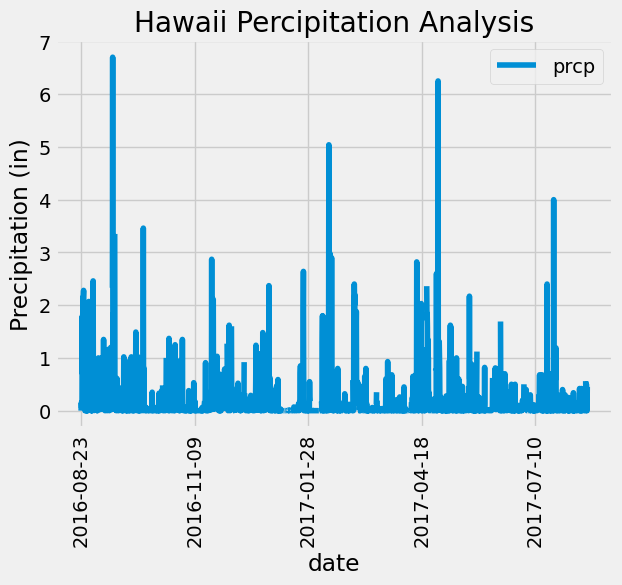

In [13]:
# Make a Plot
plt.figure(figsize=(10,12))
df1a.plot(x="date", y="prcp")
plt.title("Hawaii Percipitation Analysis")
plt.ylabel("Precipitation (in)")
plt.xticks(rotation=90) 
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for precipitation data
df1a.prcp.describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
query = text("""SELECT count(station) from station;""")
conn.execute(query).fetchall()

[(9,)]

In [16]:
session.query(func.count(Station.station)).all()

[(9,)]

In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# ORM
rows = session.query(
    Measurement.station,
    func.count(Measurement.id).label('num_observations')
).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
df2a = pd.DataFrame(rows)
df2a.head(10)

,station,num_observations
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
query = text("""SELECT
                    min(tobs) as min_tobs,
                    max(tobs) as max_tobs,
                    avg(tobs) as avg_tobs
                FROM
                    measurement
                WHERE
                    station = 'USC00519281';""")
df3 = pd.read_sql(query, con=conn)
df3.head(10)

,min_tobs,max_tobs,avg_tobs
0,54.0,85.0,71.663781


In [19]:
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# ORM
rows = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date >= '2016-08-23').order_by(Measurement.date).all()
df4a = pd.DataFrame(rows)
df4a.head()

,id,station,date,tobs
0,14608,USC00519281,2016-08-23,77.0
1,14609,USC00519281,2016-08-24,77.0
2,14610,USC00519281,2016-08-25,80.0
3,14611,USC00519281,2016-08-26,80.0
4,14612,USC00519281,2016-08-27,75.0


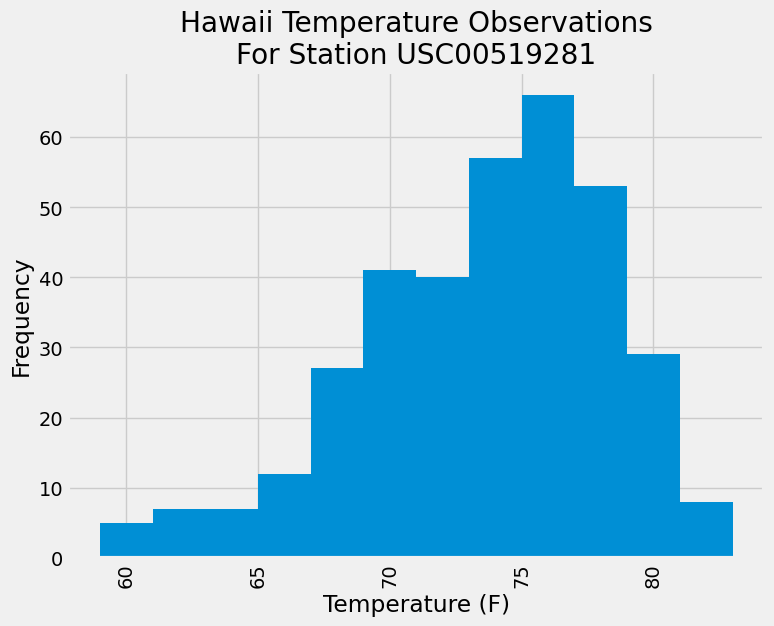

In [21]:
# Make plot
plt.figure(figsize=(8, 6))
plt.hist(df4a.tobs, bins=12)
# df1.plot(x="date", y="prcp")
plt.title("Hawaii Temperature Observations\nFor Station USC00519281")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.xticks(rotation=90)  # Rotate ticks by 90 degrees
plt.show()

# Close Session

In [22]:
# Close Session
session.close()
conn.close()

In [23]:
engine.dispose()